In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import cv2
import seaborn as sns 


input_data_path = 'images'
annotations_path = "annotations"
images = [*os.listdir("images")]
output_data_path =  '.'

In [33]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [34]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])0

df = pd.DataFrame(full_dataset)
df.shape

SyntaxError: invalid syntax (2966316444.py, line 3)

In [35]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73
5,maksssksksss1,400,156,3,with_mask,299,58,315,81
6,maksssksksss1,400,156,3,with_mask,143,74,174,115
7,maksssksksss1,400,156,3,with_mask,74,69,95,99


In [36]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [37]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os

for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [38]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [39]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [40]:
cropped_faces = [extract_faces(img, df) for img in images]

In [41]:
flat_cropped_faces = sum(cropped_faces, [])

In [42]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [43]:
print(len(with_mask))
print(len(without_mask))
print(len(mask_weared_incorrect))
print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

3231
715
123
4069


In [44]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [69]:
train_with_mask

[(<PIL.Image.Image image mode=RGBA size=61x68>, 'maksssksksss329_(44, 25)'),
 (<PIL.Image.Image image mode=RGBA size=18x25>, 'maksssksksss676_(133, 84)'),
 (<PIL.Image.Image image mode=RGBA size=42x45>, 'maksssksksss204_(278, 51)'),
 (<PIL.Image.Image image mode=RGBA size=23x24>, 'maksssksksss623_(247, 111)'),
 (<PIL.Image.Image image mode=RGB size=323x408>, 'maksssksksss106_(154, 51)'),
 (<PIL.Image.Image image mode=RGBA size=83x86>, 'maksssksksss843_(331, 205)'),
 (<PIL.Image.Image image mode=RGBA size=38x48>, 'maksssksksss105_(320, 79)'),
 (<PIL.Image.Image image mode=RGBA size=30x33>, 'maksssksksss408_(19, 46)'),
 (<PIL.Image.Image image mode=RGBA size=9x13>, 'maksssksksss603_(68, 100)'),
 (<PIL.Image.Image image mode=RGBA size=4x8>, 'maksssksksss354_(392, 109)'),
 (<PIL.Image.Image image mode=RGBA size=18x10>, 'maksssksksss603_(380, 270)'),
 (<PIL.Image.Image image mode=RGBA size=26x28>, 'maksssksksss222_(170, 104)'),
 (<PIL.Image.Image image mode=RGBA size=38x45>, 'maksssksksss70

In [45]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

In [46]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [47]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 17, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)         

In [49]:
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)


Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [50]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [51]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [53]:
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [54]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

C:\Users\parshva.karani\AppData\Local\Temp\ipykernel_10332\2632000927.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/50


50/50 [==============================] - 5s 67ms/step - loss: 0.5295 - accuracy: 0.8050 - recall: 0.7925 - precision: 0.8234 - auc: 0.9233 - val_loss: 0.5484 - val_accuracy: 0.6806 - val_recall: 0.6806 - val_precision: 0.7538 - val_auc: 0.9182 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 3s 56ms/step - loss: 0.4123 - accuracy: 0.8875 - recall: 0.8575 - precision: 0.9026 - auc: 0.9536 - val_loss: 0.3736 - val_accuracy: 0.9444 - val_recall: 0.8750 - val_precision: 0.9692 - val_auc: 0.9795 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 3s 53ms/step - loss: 0.3388 - accuracy: 0.8925 - recall: 0.8750 - precision: 0.8951 - auc: 0.9664 - val_loss: 0.2540 - val_accuracy: 0.9306 - val_recall: 0.9306 - val_precision: 0.9306 - val_auc: 0.9818 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 2s 48ms/step - loss: 0.3255 - accuracy: 0.8950 - recall: 0.8925 - precision: 0.9061 - auc: 0.9693 - val_loss: 0.3051 - val_accuracy: 0.9028 - 

In [55]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print(f'{model_loss} || {model_acc*100} || {recall*100} || {precision*100} || {auc*100}')

31/31 [==============================] - 2s 69ms/step - loss: 0.2197 - accuracy: 0.9259 - recall: 0.9259 - precision: 0.9259 - auc: 0.9875
0.21971963346004486 || 92.59259104728699 || 92.59259104728699 || 92.59259104728699 || 98.74638319015503


In [56]:
predictions = model.predict(test_generator)
predictions

31/31 [==============================] - 1s 17ms/step


array([[3.28243822e-01, 6.71727061e-01, 2.91938104e-05],
       [1.46368062e-02, 9.84980583e-01, 3.82535130e-04],
       [1.15625992e-01, 8.78068507e-01, 6.30546454e-03],
       [1.74464151e-01, 8.24699223e-01, 8.36645195e-04],
       [2.32126132e-01, 7.67850101e-01, 2.37915119e-05],
       [5.37999570e-01, 4.57586348e-01, 4.41406621e-03],
       [1.28450338e-02, 9.86495376e-01, 6.59580226e-04],
       [6.27770321e-04, 9.99372303e-01, 1.06358200e-09],
       [1.19978338e-02, 9.87991750e-01, 1.04358242e-05],
       [2.63760588e-03, 9.97353911e-01, 8.53077381e-06],
       [5.97482314e-04, 9.99402046e-01, 4.93981247e-07],
       [5.40760666e-05, 9.99945879e-01, 1.16609700e-09],
       [7.27031002e-05, 9.99927282e-01, 1.66156919e-08],
       [3.49794538e-03, 9.96501923e-01, 8.71556978e-08],
       [4.41094302e-03, 9.93413627e-01, 2.17543170e-03],
       [1.23532314e-04, 9.99876499e-01, 1.12966292e-09],
       [7.37448595e-03, 9.90161896e-01, 2.46356311e-03],
       [4.20908956e-03, 9.95764

In [57]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

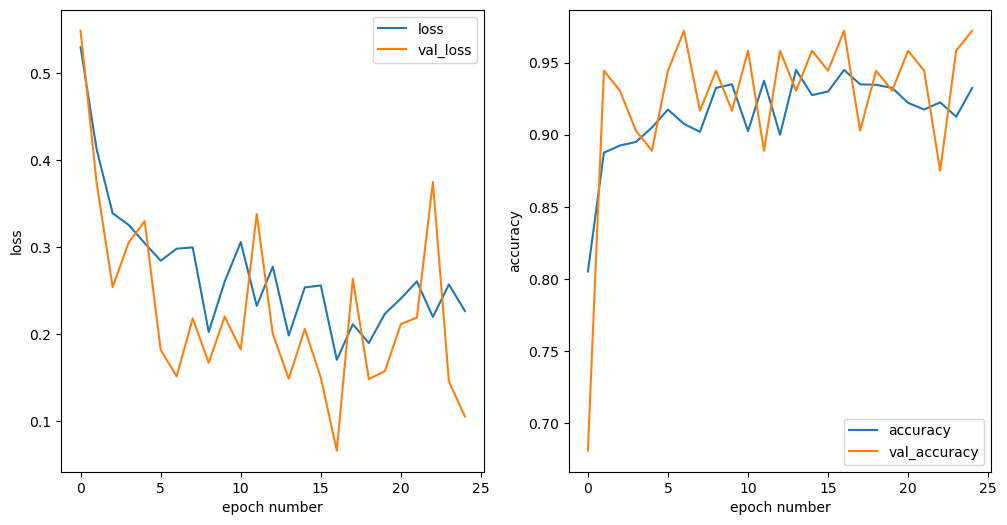

In [58]:
plot_loss_and_accuracy(model_history.history)

31/31 [==============================] - 1s 24ms/step
with_mask || with_mask


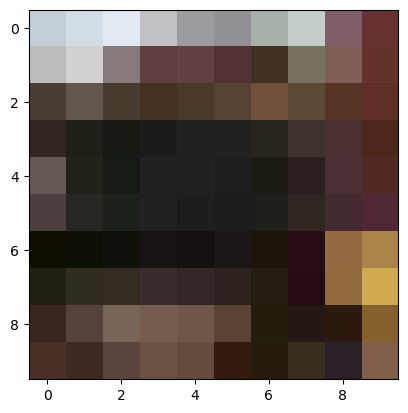

In [105]:
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = str(paths[a_img_rand].split('/')[0])
true_label = true_label.split('\\')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

In [79]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

31/31 [==============================] - 1s 20ms/step


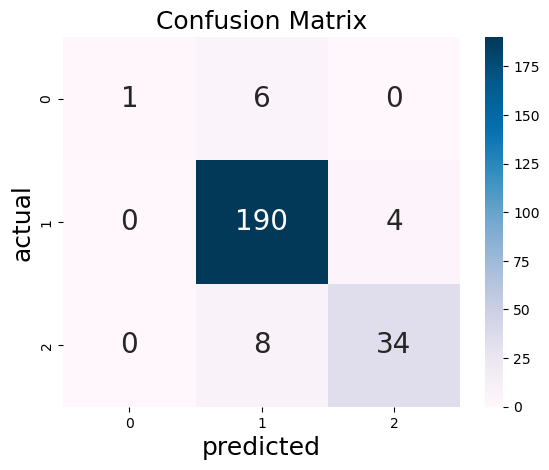

In [61]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices



evaluation(y_true, y_pred)

In [62]:
display(classes)
np.bincount(y_pred)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  1, 204,  38], dtype=int64)